In [2]:
import psycopg2
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
def promedio(espectro, nfft):
    """ Realiza promedios del espectro,
    debido a que las muestras estan almacenadas en un vector de tamano N
    que se subdivide N/nfft veces y ese es el numero que se promedia (K)"""
    K = int(len(espectro)/(nfft))
    x = numpy.zeros(nfft)
    for i in range(K):
        x = x + espectro[i*nfft:(i+1)*nfft]
    x = x/K
    return x   

In [4]:
conn = psycopg2.connect(database="centrotic", user="postgres",
                      password="raspberry", host="127.0.0.1",
                      port="5432")
cur = conn.cursor()

In [14]:
azimut = 0
nfft = 1024
frec_central = 78000000
frec_muestreo = 4000000
inidate = '2019-07-27'
enddate = '2019-09-27'
region_id = 8
query = []
query.append("SELECT radioastronomia_espectro.espectro, radioastronomia_espectro.frec_central, radioastronomia_posicionantena.elevacion, radioastronomia_espectro.fecha ")
query.append("FROM radioastronomia_espectro ")
query.append("INNER JOIN radioastronomia_posicionantena ")
query.append("ON date_trunc('second',radioastronomia_espectro.fecha)=date_trunc('second',radioastronomia_posicionantena.fecha) ")
query.append("WHERE radioastronomia_posicionantena.azimut= %s ")
query.append("AND radioastronomia_espectro.frec_central=%s ")
query.append("AND radioastronomia_espectro.frec_muestreo = %s ")
query.append("AND radioastronomia_espectro.nfft = %s ")
query.append("AND radioastronomia_espectro.region_id = %s ")
query.append("AND date_trunc('day', radioastronomia_espectro.fecha)>= to_date(%s, 'YYYY-MM-DD') ")
query.append("AND date_trunc('day', radioastronomia_espectro.fecha)<=to_date(%s, 'YYYY-MM-DD') ")
query.append("ORDER BY radioastronomia_posicionantena.elevacion;")
query = "".join(query)
print(query)

SELECT radioastronomia_espectro.espectro, radioastronomia_espectro.frec_central, radioastronomia_posicionantena.elevacion, radioastronomia_espectro.fecha FROM radioastronomia_espectro INNER JOIN radioastronomia_posicionantena ON date_trunc('second',radioastronomia_espectro.fecha)=date_trunc('second',radioastronomia_posicionantena.fecha) WHERE radioastronomia_posicionantena.azimut= %s AND radioastronomia_espectro.frec_central=%s AND radioastronomia_espectro.frec_muestreo = %s AND radioastronomia_espectro.nfft = %s AND radioastronomia_espectro.region_id = %s AND date_trunc('day', radioastronomia_espectro.fecha)>= to_date(%s, 'YYYY-MM-DD') AND date_trunc('day', radioastronomia_espectro.fecha)<=to_date(%s, 'YYYY-MM-DD') ORDER BY radioastronomia_posicionantena.elevacion;


In [15]:
cur.execute(query,[azimut, frec_central, frec_muestreo, nfft, region_id, inidate, enddate])
rows = cur.fetchall()
print(rows[0][1:])

(78000000.0, 0.0, datetime.datetime(2019, 9, 5, 19, 19, 53, 560778, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-300, name=None)))


In [16]:
ener = []
ele = []
for row in rows:
    espectro = row[0]
    elevacion = row[2]
    espectro = promedio(espectro, nfft)
    ener.append(numpy.sum(10**(espectro/10)))
    ele.append(elevacion)

In [17]:
angular = {"elevacion": ele, "energia": ener}
df = pd.DataFrame(data=angular)
df = df.groupby("elevacion")

In [18]:
dfm = df.mean()
dfm.head()

,energia
elevacion,
0.0,0.000083
90.0,0.000070
135.0,0.000070


In [19]:
elevacion = dfm.index.tolist()
elevacion = numpy.asarray(elevacion)
elevacion = elevacion*numpy.pi/180
energia = dfm["energia"].tolist()
energia = numpy.asarray(energia)
energia =energia*1e6

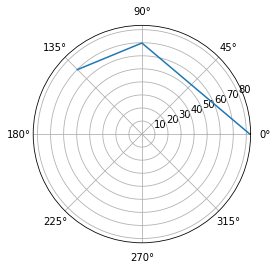

In [20]:
plt.polar(elevacion, energia)